In [1]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, torchvision
import matplotlib.pyplot as plt

device = torch.device('cuda')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

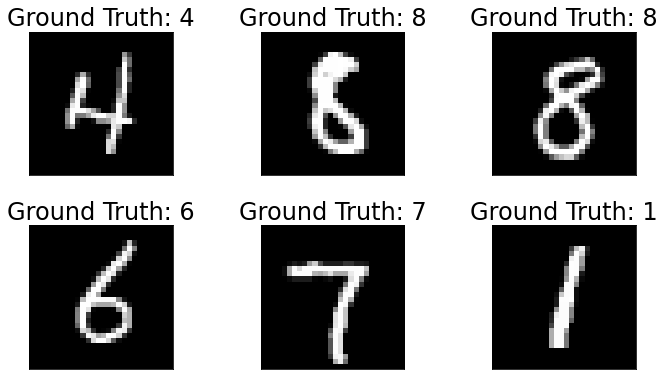

In [2]:
batch_size_train = 20
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./mnist_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig, ax = plt.subplots(figsize=(10,6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [3]:
# grab one image of each class
balanced_data = torch.zeros((10,1,28,28))
for i in range(10):
    target_idx = next((idx for idx,target in enumerate(example_targets) if target==i))
    balanced_data[i,:,:,:] = example_data[target_idx] 

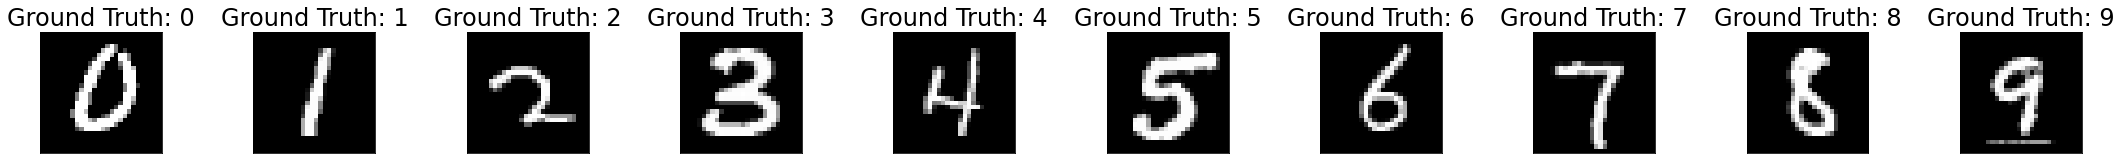

In [4]:
# fig, ax = plt.subplots(figsize=(15,6))
fig, ax = plt.subplots(figsize=(30,3))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(balanced_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(i))
  plt.xticks([])
  plt.yticks([])

# Unconstrained Generator

### Testing one kernel+hyperparameter setting at a time

In [5]:
# format images as training vectors and init generated points
X_true = balanced_data.flatten(start_dim=1)
n_true, d = X_true.shape
p_true = torch.ones(n_true).softmax(-1)

# initialize generated points
n_gen, r = 10, 50
X_gen_init = torch.rand(size=(n_gen, d))
p_gen = torch.ones(n_gen).softmax(-1)
# G = PointGenerator(X_gen_init, p_gen, device=device)
G = PointGenerator(X_gen_init, p_gen, device=device)

# set kernel parameters
width_param=5
mix_param=0.5
depth=2
# DK = Kernel('gaussian', width_param=20)
# DK = Kernel('rq', width_param=width_param, mix_param=mix_param)
DK = Kernel('nngp', depth=depth)

In [6]:
# training params
T, lr_d, lr_g, lam = 1000, 1, 1, 1e-2
log_interval=20
# find generated trajectories
D = KernelDiscriminator(DK, d, lam, lr_d, device)
model = KernelGAN(G, D, device)
model.train(X_true, p_true, lr_d, lr_g, T, lam, e_threshold=1e-1, 
            log_interval=log_interval, log_grad=True)
curr_w2 = wasserstein2(model.G.X_gen.detach(), X_true.detach().to(device), log_interval, device=device)

100%|██████████| 50/50 [00:00<00:00, 661.65it/s]


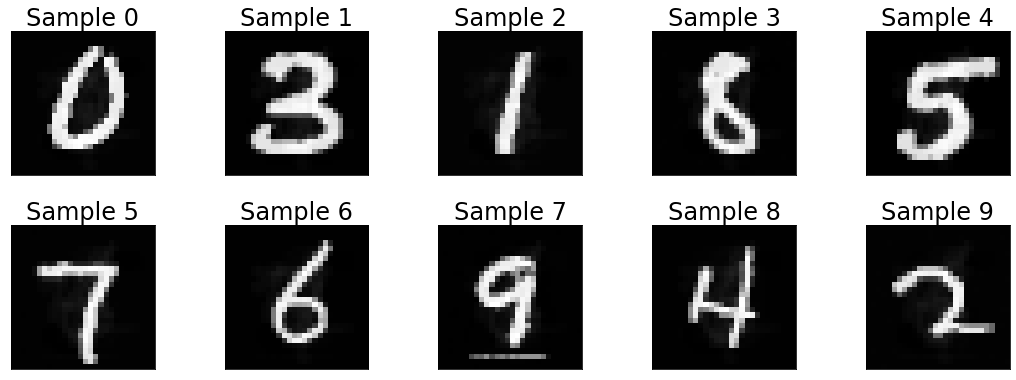

In [7]:
trained_images = model.G.X_gen[-1,:,:].reshape(balanced_data.shape).detach().cpu().numpy()
# sample_map = [3,4,0,7,2,9,6,5,8,1] # RQ
# sample_map = [9,0,4,1,2,5,3,6,8,7] # G
sample_map = [1,9,4,5,7,3,2,0,6,8] # NNGP
fig, ax = plt.subplots(figsize=(15,6))
for i, im in enumerate(range(10)):
  plt.subplot(2,5,i+1)
  plt.tight_layout()
  # plt.imshow(trained_images[i][0], cmap='gray', interpolation='none')
  plt.imshow(trained_images[sample_map[i]][0], cmap='gray', interpolation='none')
  plt.title(f"Sample {i}")
  plt.xticks([])
  plt.yticks([])

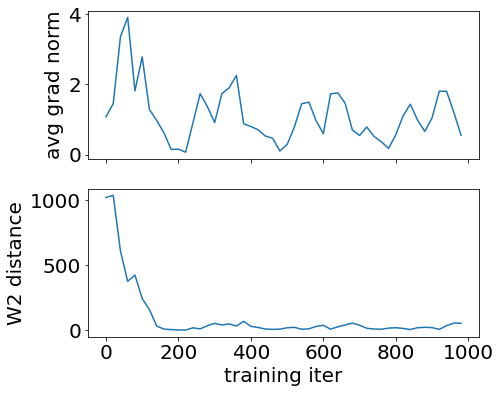

In [8]:
fig, ax  = plt.subplots(2,1, figsize=(7,6), sharex=True)
avg_norm_grad = [ang.detach().cpu() for ang in model.avg_norm_grad]
ax[0].plot(list(range(0,T,log_interval)), avg_norm_grad)
ax[0].set_ylabel('avg grad norm')

ax[1].plot(list(range(0,T,log_interval)), curr_w2.detach().cpu())
ax[1].set_ylabel('W2 distance')
ax[1].set_xlabel('training iter')
plt.show()

### Hyperparam scan w/ Multiple initialization

In [93]:
# format images as training vectors and init generated points
X_true = balanced_data.flatten(start_dim=1)
n_true, d = X_true.shape
p_true = torch.ones(n_true).softmax(-1)

# set kernel parameters
width_params= [5,10,20,30]
mix_param=0.5
depth_params=[2,3,4]

# training params
trials = 3
T, lr_d, lr_g, lam = 3000, 1, 1, 1e-2
log_interval=20

Wdist = torch.zeros((trials, len(width_params), T//log_interval))
for trial_idx in range(trials):
    # initialize generated points
    n_gen = 10
    X_gen_init = torch.rand(size=(n_gen, d))
    p_gen = torch.ones(n_gen).softmax(-1)
    for width_idx, width_param in enumerate(width_params):
    # for width_idx, depth_param in enumerate(depth_params):
        # init generator
        G = PointGenerator(X_gen_init, p_gen, device=device)
        # init discriminator
        DK = Kernel('gaussian', width_param=width_param)
        # DK = Kernel('rq', width_param=width_param, mix_param=mix_param)
        # DK = Kernel('nngp', depth=depth_param)
        D = KernelDiscriminator(DK, d, lam, lr_d, device)
        # find generated trajectories
        model = KernelGAN(G, D, device)
        model.train(X_true, p_true, lr_d, lr_g, T, lam, e_threshold=1e-1, 
                    log_interval=log_interval, log_grad=True)
        curr_w2 = wasserstein2(model.G.X_gen.detach(), X_true.detach().to(device), log_interval, device=device)
        Wdist[trial_idx, width_idx,:] = curr_w2.detach().cpu()

100%|██████████| 150/150 [00:00<00:00, 1135.15it/s]


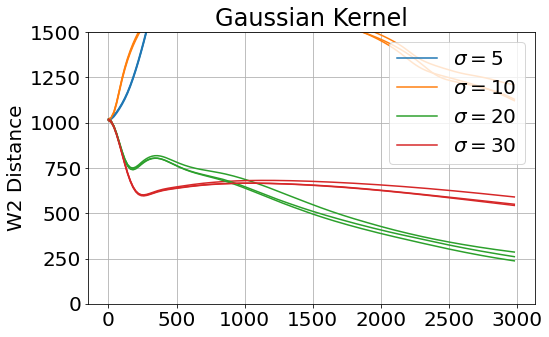

In [94]:
fig, ax = plt.subplots(figsize=(8,5))
for trial_idx in range(trials):
    for width_idx, width_param in enumerate(width_params):
    # for width_idx, depth_param in enumerate(depth_params):
        ax.plot(list(range(0,T,log_interval)), Wdist[trial_idx,width_idx], 
                    # c=f'C{width_idx}', label=f'$depth={depth_param}$')
                    c=f'C{width_idx}', label=f'$\sigma={width_param}$')
        ax.set_ylim(0,1500)
        # ax.set_ylim(0,3000)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('Gaussian Kernel')
# plt.title(f'RQ Kernel ($\\alpha={mix_param}$)')
# plt.title('NNGP Kernel')
plt.ylabel('W2 Distance')
plt.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.grid()

# FC Generator

In [3]:
# format images as training vectors and init generated points
X_true = example_data.flatten(start_dim=1)
p_true = torch.ones(batch_size_train).softmax(-1)
n_true, d = X_true.shape

# initialize generated points
n_gen, r = batch_size_train, 500
Z_gen = torch.normal(mean=torch.zeros(n_gen,r))
p_gen = torch.ones(n_gen).softmax(-1)
G = ReLUGenerator(d, Z_gen, p_gen, device=device)

# set kernel parameters
width_param=20
mix_param=1
depth=3
# DK = Kernel('laplacian', width_param=width_param)
DK = Kernel('rq', width_param=width_param, mix_param=mix_param)
# DK = Kernel('nngp', depth=depth)

In [4]:
# training params
T, lr_d, lr_g, lam = 2000, 1e-1, 1e-1, 5e-1
log_interval=20
# find generated trajectories
D = KernelDiscriminator(DK, d, lam, lr_d, device)
model = KernelGAN(G, D, device)
model.train(X_true, p_true, lr_d, lr_g, T, lam, e_threshold=1e-1, 
            log_interval=log_interval, log_grad=True)
curr_w2 = wasserstein2(model.G.X_gen.detach(), X_true.detach().to(device), log_interval, device=device)

100%|██████████| 100/100 [00:00<00:00, 643.43it/s]


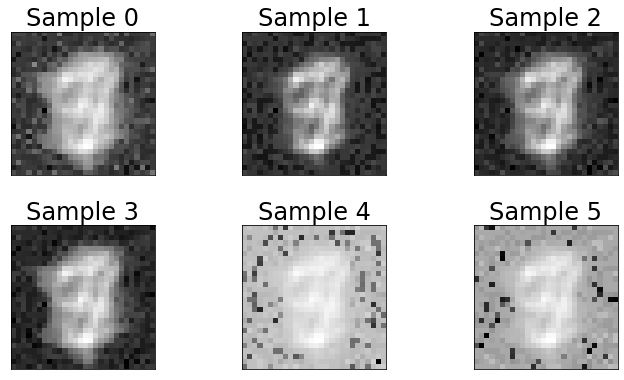

In [5]:
trained_images = model.G.X_gen[-1,:,:].reshape(example_data.shape).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(10,6))
for i, im in enumerate(range(6)):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trained_images[i][0], cmap='gray', interpolation='none')
  plt.title(f"Sample {i}")
  plt.xticks([])
  plt.yticks([])

# plt.savefig("../data/mnist_nngp5_2kiters.png", format='png', bbox_inches='tight')

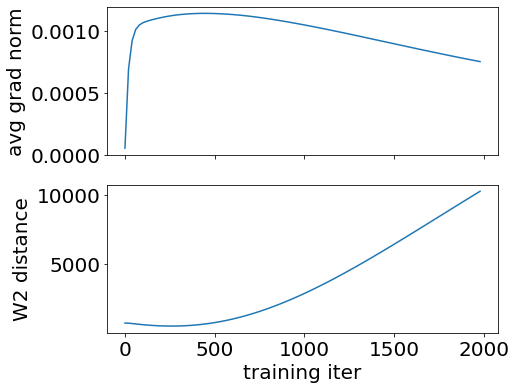

In [6]:
fig, ax  = plt.subplots(2,1, figsize=(7,6), sharex=True)
avg_norm_grad = [ang.detach().cpu() for ang in model.avg_norm_grad]
ax[0].plot(list(range(0,T,log_interval)), avg_norm_grad)
ax[0].set_ylabel('avg grad norm')

ax[1].plot(list(range(0,T,log_interval)), curr_w2.detach().cpu())
ax[1].set_ylabel('W2 distance')
ax[1].set_xlabel('training iter')
plt.show()

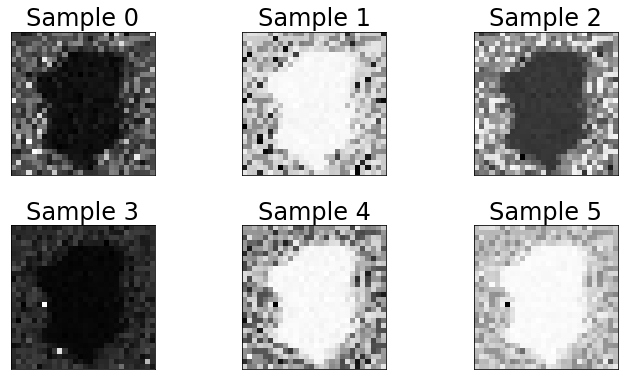

In [7]:
Z_test = torch.normal(mean=torch.zeros(X_true.shape[0],r)).to(device)
X_test = Z_test@model.G.W

trained_images = X_test.reshape(example_data.shape).detach().cpu()
fig, ax = plt.subplots(figsize=(10,6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trained_images[i][0], cmap='gray', interpolation='none')
  plt.title(f"Sample {i}")
  plt.xticks([])
  plt.yticks([])

# DC Generator

In [5]:
# format images as training vectors and init generated points
X_true = balanced_data.flatten(start_dim=1)
n_true, d = X_true.shape
p_true = torch.ones(n_true).softmax(-1)

# initialize generated points
n_gen, z_dim = 10, 50
Z_gen = torch.normal(mean=torch.zeros(n_gen,z_dim))
p_gen = torch.ones(n_gen).softmax(-1)

# set kernel parameters
width_param=20
mix_param=5
depth=2
# DK = Kernel('laplacian', width_param=width_param)
# DK = Kernel('rq', width_param=width_param, mix_param=mix_param)
DK = Kernel('nngp', depth=depth)

In [6]:
# training params
T, lr_d, lr_g, lam = 1000, 5e-2, 1e-2, 5e-1
log_interval=20
# find generated trajectories
D = KernelDiscriminator(DK, d, lam, lr_d, device)
G = DCGenerator(d, Z_gen, p_gen, lr_g, device=device)
model = KernelGAN(G, D, device)
model.train(X_true, p_true, lr_d, lr_g, T, lam, e_threshold=1e-2, 
            log_interval=log_interval, log_grad=True, resample_interval=1)
curr_w2 = wasserstein2(model.G.X_gen.detach(), X_true.detach().to('cpu'), log_interval, device='cpu')

100%|██████████| 50/50 [00:00<00:00, 1015.48it/s]


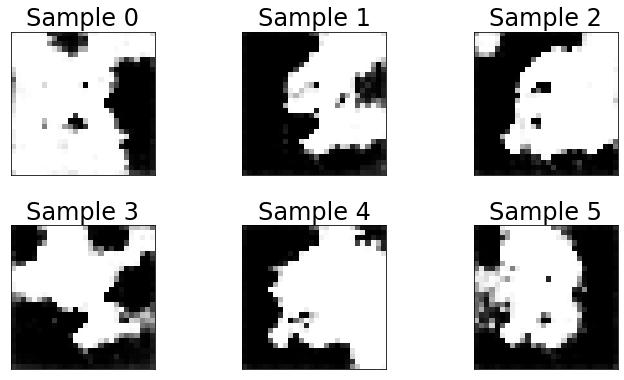

In [8]:
trained_images = model.G.X_gen[-1,:,:].reshape([n_gen,1,28,28]).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(10,6))
for i, im in enumerate(range(6)):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trained_images[i][0], cmap='gray', interpolation='none')
  plt.title(f"Sample {i}")
  plt.xticks([])
  plt.yticks([])

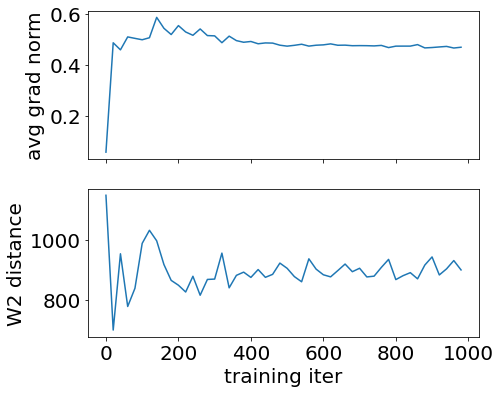

In [9]:
fig, ax  = plt.subplots(2,1, figsize=(7,6), sharex=True)
avg_norm_grad = [ang.detach().cpu() for ang in model.avg_norm_grad]
ax[0].plot(list(range(0,T,log_interval)), avg_norm_grad)
ax[0].set_ylabel('avg grad norm')

ax[1].plot(list(range(0,T,log_interval)), curr_w2.detach().cpu())
ax[1].set_ylabel('W2 distance')
ax[1].set_xlabel('training iter')
plt.show()

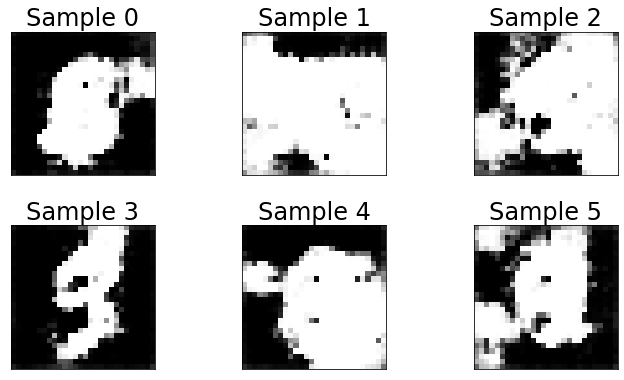

In [19]:
Z_test = torch.normal(mean=torch.zeros(X_true.shape[0],z_dim)).to(device)
X_test = G.generate(Z_test)

trained_images = X_test.reshape(balanced_data.shape).detach().cpu()
fig, ax = plt.subplots(figsize=(10,6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trained_images[i][0], cmap='gray', interpolation='none')
  plt.title(f"Sample {i}")
  plt.xticks([])
  plt.yticks([])